## 1. Import libraries

In [1]:
import sys
sys.path.append('../')

%matplotlib inline
from collections import defaultdict
from typing import List
from sklearn.preprocessing import StandardScaler

import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import gym

import src.agents as agents
import src.episode as episode
import src.environment as environment
import src.aux_plots as aux_plots

## 2. Auxiliary functions

### 2.1. Reduce state space

In [2]:
def reduce_state(ob):
    # Doesn't matter where we were hit
    ob[16] = 1 if ob[16] != 255 else 0

    # Reduce chicken y-position
    ob[14] = ob[14] // 3

    for b in range(108, 118):
        # The chicken is in the x-posistion ~49
        if ob[b] < 20 or ob[b] > 80:
            # We don't need to represent cars far from the chicken
            ob[b] = 0
        else:
            # Reduce the cars x-positions sample space
            ob[b] = ob[b] // 3

    return ob

### 2.2. Reward policy

In [3]:
def reward_policy(reward, ob, action):
    if reward == 1:
        reward = reward_policy.REWARD_IF_CROSS
    elif ob[16] == 1:  # Collision!
        reward = reward_policy.REWARD_IF_COLISION
    elif action != 1:  # Don't incentivate staying still
        reward = reward_policy.REWARD_IF_STILL

    return reward

### 2.3. Print results

In [4]:
def print_result(i, scores, total_reward, score):
#     if i % 10 == 0:
        print(f"Run [{i:4}] - Total reward: {total_reward:7.2f} Mean scores: {sum(scores) / len(scores):.2f} Means Scores[:-10]: {sum(scores[-10:]) / len(scores[-10:]):5.2f} Score: {score:2} ")

## 3. Running algorithms

### 3.1. Hyperparameters

In [5]:
RAM_mask = [
      14  # Chicken Y
    , 16  # Chicken Lane Collide
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117  # Car X Coords
]

GAMMA = 0.99
AVAILABLE_ACTIONS = 2
N0 = 2.5

reward_policy.REWARD_IF_CROSS = 50
reward_policy.REWARD_IF_COLISION = -1
reward_policy.REWARD_IF_STILL = -0.1

### 3.2. Monte Carlo

In [ ]:
env, initial_state = environment.get_env()

mc_agent = agents.MonteCarloControl(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

In [ ]:
def MonteCarloES(agent, reduce_s, reward_p, RAM_mask: List[int], render: bool=False):
    epi = episode.generate_episode(env, reduce_state=reduce_s, reward_policy=reward_p, agent=agent, RAM_mask=RAM_mask, render=render)
    return agent.update_policy(epi)

In [ ]:
# %%time
# MonteCarloES(agent=mc_agent,reduce_s=reduce_state, reward_p=reward_policy, RAM_mask=RAM_mask, render=False)

In [ ]:
%%time
scores = []
total_rewards = []


n_runs = 5

for i in range(n_runs):
    render = i % 201 == 200

    score, total_reward = MonteCarloES(agent=mc_agent,reduce_s=reduce_state, reward_p=reward_policy, RAM_mask=RAM_mask, render=render)

    scores.append(score)
    total_rewards.append(total_reward)

    print_result(i, scores, total_reward, score)

### 3.3. Q Learning

In [ ]:
env, initial_state = environment.get_env()
ql_agent = agents.QLearning(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0)

In [ ]:
%%time
scores = []
total_rewards = []

n_runs = 1
render = False
for i in range(n_runs):
#     render = i % 200 == 0

    game_over = False
    state = env.reset()
    state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
    action = ql_agent.act(state)
    
    score = 0
    total_reward = 0

    while not game_over:
        if render:
            time.sleep(0.025)
            env.render()

        old_state = state
        ob, reward, game_over, _ = env.step(action)

        ob = reduce_state(ob)
        reward = reward_policy(reward, ob, action)

        total_reward += reward

        if reward == reward_policy.REWARD_IF_CROSS:
            score += 1

        state = ob[RAM_mask].data.tobytes()

        ql_agent.update_Q(old_state, state, action, reward)

        action = ql_agent.act(state)  # Next action

    scores.append(score)
    total_rewards.append(total_reward)

    print_result(i, scores, total_reward, score)

In [ ]:
for key in ql_agent.Q:
    print('{}:{}'.format(np.frombuffer(key, dtype=np.uint8, count=-1), ql_agent.Q[key]))

### 3.4. Q Learning Approximator

In [6]:
env, initial_state = environment.get_env()
ql_agent_app = agents.QLearningLinearApprox(gamma=GAMMA, available_actions=AVAILABLE_ACTIONS, N0=N0, weights_length=len(RAM_mask))
ql_agent_app.trainScaler(env, RAM_mask)

In [7]:
state = env.reset()
ql_agent_app.createFeature(reduce_state(state)[RAM_mask].data.tobytes(), 1)

array([0.02725166, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 1.        ])

In [8]:
%%time
scores = []
total_rewards = []

n_runs = 1
render = False
for i in range(n_runs):
#     render = i % 200 == 0

    game_over = False
    state = env.reset()
    state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
    action = ql_agent_app.act(state)
    
    score = 0
    total_reward = 0

    count = 0
    print("Episode ",i)
    while not game_over:
        if render:
            time.sleep(0.025)
            env.render()

        old_state = state
        ob, reward, game_over, _ = env.step(action)

        ob = reduce_state(ob)
        reward = reward_policy(reward, ob, action)

        total_reward += reward

        if reward == reward_policy.REWARD_IF_CROSS:
            score += 1

        state = ob[RAM_mask].data.tobytes()
        print("Run ", count)
        ql_agent_app.update_W(old_state, state, action, reward)

        action = ql_agent_app.act(state)  # Next action
        count+=1
        print('------------------------------------')
    scores.append(score)
    total_rewards.append(total_reward)

    print_result(i, scores, total_reward, score)

Episode  0
Run  0
------------------------------------
Run  1
------------------------------------
Run  2
------------------------------------
Run  3
------------------------------------
Run  4
------------------------------------
Run  5
------------------------------------
Run  6
------------------------------------
Run  7
------------------------------------
Run  8
------------------------------------
Run  9
------------------------------------
Run  10
------------------------------------
Run  11
------------------------------------
Run  12
------------------------------------
Run  13
------------------------------------
Run  14
------------------------------------
Run  15
------------------------------------
Run  16
------------------------------------
Run  17
------------------------------------
Run  18
------------------------------------
Run  19
------------------------------------
Run  20
------------------------------------
Run  21
------------------------------------
Run  22
-

------------------------------------
Run  190
------------------------------------
Run  191
------------------------------------
Run  192
------------------------------------
Run  193
------------------------------------
Run  194
------------------------------------
Run  195
------------------------------------
Run  196
------------------------------------
Run  197
------------------------------------
Run  198
------------------------------------
Run  199
------------------------------------
Run  200
------------------------------------
Run  201
------------------------------------
Run  202
------------------------------------
Run  203
------------------------------------
Run  204
------------------------------------
Run  205
------------------------------------
Run  206
------------------------------------
Run  207
------------------------------------
Run  208
------------------------------------
Run  209
------------------------------------
Run  210
----------------------------------

Run  395
------------------------------------
Run  396
------------------------------------
Run  397
------------------------------------
Run  398
------------------------------------
Run  399
------------------------------------
Run  400
------------------------------------
Run  401
------------------------------------
Run  402
------------------------------------
Run  403
------------------------------------
Run  404
------------------------------------
Run  405
------------------------------------
Run  406
------------------------------------
Run  407
------------------------------------
Run  408
------------------------------------
Run  409
------------------------------------
Run  410
------------------------------------
Run  411
------------------------------------
Run  412
------------------------------------
Run  413
------------------------------------
Run  414
------------------------------------
Run  415
------------------------------------
Run  416
-------------------------

Run  606
------------------------------------
Run  607
------------------------------------
Run  608
------------------------------------
Run  609
------------------------------------
Run  610
------------------------------------
Run  611
------------------------------------
Run  612
------------------------------------
Run  613
------------------------------------
Run  614
------------------------------------
Run  615
------------------------------------
Run  616
------------------------------------
Run  617
------------------------------------
Run  618
------------------------------------
Run  619
------------------------------------
Run  620
------------------------------------
Run  621
------------------------------------
Run  622
------------------------------------
Run  623
------------------------------------
Run  624
------------------------------------
Run  625
------------------------------------
Run  626
------------------------------------
Run  627
-------------------------

------------------------------------
Run  813
------------------------------------
Run  814
------------------------------------
Run  815
------------------------------------
Run  816
------------------------------------
Run  817
------------------------------------
Run  818
------------------------------------
Run  819
------------------------------------
Run  820
------------------------------------
Run  821
------------------------------------
Run  822
------------------------------------
Run  823
------------------------------------
Run  824
------------------------------------
Run  825
------------------------------------
Run  826
------------------------------------
Run  827
------------------------------------
Run  828
------------------------------------
Run  829
------------------------------------
Run  830
------------------------------------
Run  831
------------------------------------
Run  832
------------------------------------
Run  833
----------------------------------

------------------------------------
Run  1012
------------------------------------
Run  1013
------------------------------------
Run  1014
------------------------------------
Run  1015
------------------------------------
Run  1016
------------------------------------
Run  1017
------------------------------------
Run  1018
------------------------------------
Run  1019
------------------------------------
Run  1020
------------------------------------
Run  1021
------------------------------------
Run  1022
------------------------------------
Run  1023
------------------------------------
Run  1024
------------------------------------
Run  1025
------------------------------------
Run  1026
------------------------------------
Run  1027
------------------------------------
Run  1028
------------------------------------
Run  1029
------------------------------------
Run  1030
------------------------------------
Run  1031
------------------------------------
Run  1032
-------------

------------------------------------
Run  1192
------------------------------------
Run  1193
------------------------------------
Run  1194
------------------------------------
Run  1195
------------------------------------
Run  1196
------------------------------------
Run  1197
------------------------------------
Run  1198
------------------------------------
Run  1199
------------------------------------
Run  1200
------------------------------------
Run  1201
------------------------------------
Run  1202
------------------------------------
Run  1203
------------------------------------
Run  1204
------------------------------------
Run  1205
------------------------------------
Run  1206
------------------------------------
Run  1207
------------------------------------
Run  1208
------------------------------------
Run  1209
------------------------------------
Run  1210
------------------------------------
Run  1211
------------------------------------
Run  1212
-------------

Run  1410
------------------------------------
Run  1411
------------------------------------
Run  1412
------------------------------------
Run  1413
------------------------------------
Run  1414
------------------------------------
Run  1415
------------------------------------
Run  1416
------------------------------------
Run  1417
------------------------------------
Run  1418
------------------------------------
Run  1419
------------------------------------
Run  1420
------------------------------------
Run  1421
------------------------------------
Run  1422
------------------------------------
Run  1423
------------------------------------
Run  1424
------------------------------------
Run  1425
------------------------------------
Run  1426
------------------------------------
Run  1427
------------------------------------
Run  1428
------------------------------------
Run  1429
------------------------------------
Run  1430
------------------------------------
Run  1431
---

------------------------------------
Run  1620
------------------------------------
Run  1621
------------------------------------
Run  1622
------------------------------------
Run  1623
------------------------------------
Run  1624
------------------------------------
Run  1625
------------------------------------
Run  1626
------------------------------------
Run  1627
------------------------------------
Run  1628
------------------------------------
Run  1629
------------------------------------
Run  1630
------------------------------------
Run  1631
------------------------------------
Run  1632
------------------------------------
Run  1633
------------------------------------
Run  1634
------------------------------------
Run  1635
------------------------------------
Run  1636
------------------------------------
Run  1637
------------------------------------
Run  1638
------------------------------------
Run  1639
------------------------------------
Run  1640
-------------

------------------------------------
Run  1827
------------------------------------
Run  1828
------------------------------------
Run  1829
------------------------------------
Run  1830
------------------------------------
Run  1831
------------------------------------
Run  1832
------------------------------------
Run  1833
------------------------------------
Run  1834
------------------------------------
Run  1835
------------------------------------
Run  1836
------------------------------------
Run  1837
------------------------------------
Run  1838
------------------------------------
Run  1839
------------------------------------
Run  1840
------------------------------------
Run  1841
------------------------------------
Run  1842
------------------------------------
Run  1843
------------------------------------
Run  1844
------------------------------------
Run  1845
------------------------------------
Run  1846
------------------------------------
Run  1847
-------------

------------------------------------
Run  2051
------------------------------------
Run  2052
------------------------------------
Run  2053
------------------------------------
Run  2054
------------------------------------
Run  2055
------------------------------------
Run  2056
------------------------------------
Run  2057
------------------------------------
Run  2058
------------------------------------
Run  2059
------------------------------------
Run  2060
------------------------------------
Run  2061
------------------------------------
Run  2062
------------------------------------
Run  2063
------------------------------------
Run  2064
------------------------------------
Run  2065
------------------------------------
Run  2066
------------------------------------
Run  2067
------------------------------------
Run  2068
------------------------------------
Run  2069
------------------------------------
Run  2070
------------------------------------
Run  2071
-------------

------------------------------------
Run  2243
------------------------------------
Run  2244
------------------------------------
Run  2245
------------------------------------
Run  2246
------------------------------------
Run  2247
------------------------------------
Run  2248
------------------------------------
Run  2249
------------------------------------
Run  2250
------------------------------------
Run  2251
------------------------------------
Run  2252
------------------------------------
Run  2253
------------------------------------
Run  2254
------------------------------------
Run  2255
------------------------------------
Run  2256
------------------------------------
Run  2257
------------------------------------
Run  2258
------------------------------------
Run  2259
------------------------------------
Run  2260
------------------------------------
Run  2261
------------------------------------
Run  2262
------------------------------------
Run  2263
-------------

Run  2428
------------------------------------
Run  2429
------------------------------------
Run  2430
------------------------------------
Run  2431
------------------------------------
Run  2432
------------------------------------
Run  2433
------------------------------------
Run  2434
------------------------------------
Run  2435
------------------------------------
Run  2436
------------------------------------
Run  2437
------------------------------------
Run  2438
------------------------------------
Run  2439
------------------------------------
Run  2440
------------------------------------
Run  2441
------------------------------------
Run  2442
------------------------------------
Run  2443
------------------------------------
Run  2444
------------------------------------
Run  2445
------------------------------------
Run  2446
------------------------------------
Run  2447
------------------------------------
Run  2448
------------------------------------
Run  2449
---

------------------------------------
Run  2622
------------------------------------
Run  2623
------------------------------------
Run  2624
------------------------------------
Run  2625
------------------------------------
Run  2626
------------------------------------
Run  2627
------------------------------------
Run  2628
------------------------------------
Run  2629
------------------------------------
Run  2630
------------------------------------
Run  2631
------------------------------------
Run  2632
------------------------------------
Run  2633
------------------------------------
Run  2634
------------------------------------
Run  2635
------------------------------------
Run  2636
------------------------------------
Run  2637
------------------------------------
Run  2638
------------------------------------
Run  2639
------------------------------------
Run  2640
------------------------------------
Run  2641
------------------------------------
Run  2642
-------------

In [13]:
with open("scores.txt", "w") as f:
    for s,tr in zip(scores, total_rewards):
        f.write("{}, {}\n".format(s, tr))

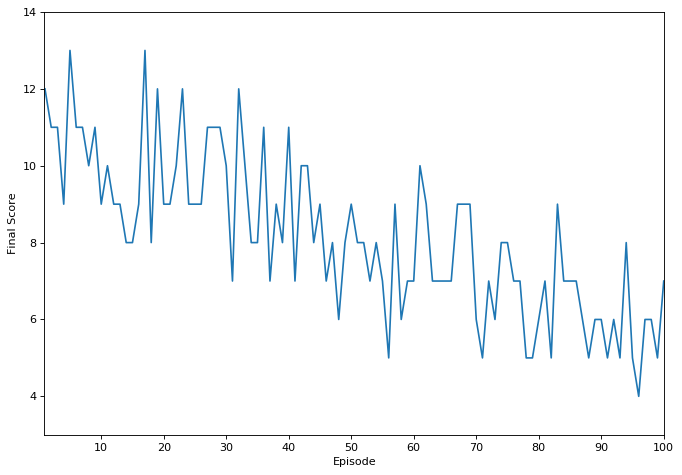

In [14]:
aux_plots.plot_scores(scores)

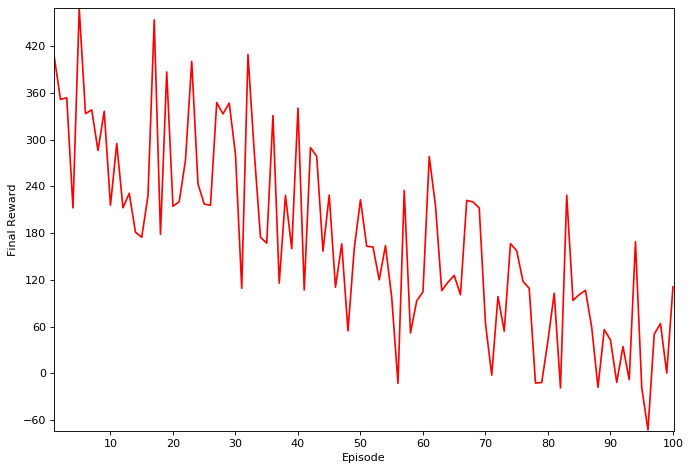

In [15]:
aux_plots.plot_rewards(total_rewards)

In [ ]:
ql_agent_app.update_W(old_state, state, action, reward)

In [ ]:
old_state, state, action, reward

In [ ]:
teste = np.frombuffer(state, dtype=np.uint8, count=-1)
teste.reshape(1,-1)

In [ ]:
from sklearn.preprocessing import normalize

In [ ]:
normalize(teste.reshape(1,-1), norm='l1', axis=0)

In [ ]:
scaler = StandardScaler(with_mean=False)
observation_examples = np.array([env.observation_space.sample()[RAM_mask] for x in range(10000)])
scaler.fit(observation_examples)

In [ ]:
scaler.transform([[1,0,1,0,0,1,0,1,0,0,1,1]])